In [17]:
import numpy as np
import pandas as pd
from sklearn import linear_model
from sklearn.cross_validation import train_test_split
from sklearn.cross_validation import KFold
import matplotlib.pyplot as plt
plt.style.use('bmh')
%matplotlib inline

In [18]:
train_raw = pd.read_csv('data_sets/train.csv')

In [19]:
def preprocess(data):
    gender_map = {'male':1,'female':0}
    embarked_map = {'C':0,'Q':1,'S':2}
    data['Sex'] = data['Sex'].map(gender_map)
    data['Embarked'] = data['Embarked'].map(embarked_map)
    data.fillna(-1,inplace=True)
    return data

In [20]:
train = preprocess(train_raw)
ignore = ['Name','Ticket','Cabin']
train_x = train.drop(['Survived']+ignore,axis=1)
train_y = train['Survived']
print train_x.shape
print train_y.shape

(891, 8)
(891,)


In [21]:
X_train, X_valid, Y_train, Y_valid = train_test_split(train_x, train_y, test_size=100, random_state=0)

In [22]:
lrm = linear_model.LogisticRegression(C=1.)
lrm.fit(X_train,Y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr',
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0)

In [23]:
predictions = lrm.predict(X_valid)

In [24]:
def calc_error(precitions,actuals):
    return np.sum(predictions != actuals,dtype=float)
def error_rate(predictions,actuals):
    return calc_error(predictions,actuals)/len(predictions)

In [25]:
print error_rate(predictions,Y_valid.values)

0.19


# Naive Guess on Test Data!!!!

In [26]:
test_data = pd.read_csv('data_sets/test.csv')
test = test_data.copy()

In [27]:
test = preprocess(test_data)
test_x = test.drop(ignore,axis=1)

In [28]:
lrm_test = linear_model.LogisticRegression(C=1.)
lrm_test.fit(train_x, train_y)
test_predictions = lrm_test.predict(test_x)
print test_predictions

[0 1 0 0 1 0 1 0 1 0 0 0 1 0 1 1 0 0 1 1 0 0 1 1 1 0 1 0 0 0 0 0 1 1 0 0 1
 1 0 0 0 0 0 1 1 0 0 0 1 1 0 0 1 1 0 0 0 0 0 1 0 0 0 1 1 1 1 0 0 1 1 0 1 0
 1 1 0 1 0 1 0 0 0 0 0 0 1 1 1 0 1 0 1 0 0 0 1 0 1 0 1 0 0 0 1 0 0 0 0 0 0
 1 1 1 1 0 0 1 1 1 1 0 1 0 0 1 0 1 0 0 0 0 1 0 0 0 0 0 1 0 0 1 1 0 0 0 1 0
 0 0 1 0 0 1 0 0 1 1 0 1 1 0 1 0 0 1 0 0 1 1 0 0 0 0 0 1 1 0 1 1 0 0 1 0 1
 0 1 0 0 0 0 0 0 0 0 0 1 1 0 1 1 0 1 1 0 1 1 0 1 0 0 0 0 1 0 0 1 0 1 0 1 0
 1 0 1 1 0 1 0 0 0 1 0 0 0 0 0 0 1 1 1 1 0 0 0 0 1 0 1 1 1 0 1 0 0 0 0 0 1
 0 0 0 1 1 0 0 0 0 1 0 0 0 1 1 0 1 0 0 0 0 1 0 1 1 1 0 0 0 0 0 1 1 0 0 0 0
 1 0 0 0 0 0 0 0 1 1 0 0 0 1 0 0 0 1 1 1 0 0 0 0 0 0 0 0 1 0 1 0 0 0 1 0 0
 1 0 0 0 0 0 0 0 0 0 1 0 1 0 1 0 1 1 0 0 0 1 0 1 0 0 1 0 1 1 0 1 1 0 1 1 0
 0 1 0 0 1 1 1 0 0 0 0 0 1 1 0 1 0 0 0 0 1 1 0 0 0 1 0 1 0 0 1 0 1 0 0 0 0
 1 1 1 1 1 1 0 1 0 0 0]


In [29]:
ids = np.arange(1,len(test_predictions)+1)
np.savetxt('titanic_naive.csv',
           np.c_[test_x['PassengerId'],test_predictions],
           delimiter=',',
           header='PassengerId,Survived',
           fmt='%d',
           comments='')

In [30]:
k = 10
penalty_range = np.logspace(-10,10,21)
errors_l2 = []
errors_l1 = []
for penalty in penalty_range:
    kfold = KFold(len(X_train), n_folds=k,shuffle=True,random_state=0)
    error_l2 = 0
    error_l1 = 0
    for train_index, val_index in kfold:
        x_train = X_train.iloc[train_index]
        y_train = Y_train.iloc[train_index]
        x_val = X_train.iloc[val_index]
        y_val = Y_train.iloc[val_index]
        lrm_l2 = linear_model.LogisticRegression(C=1./penalty,penalty='l2')
        lrm_l1 = linear_model.LogisticRegression(C=1./penalty,penalty='l1')
        lrm_l2.fit(x_train,y_train)
        lrm_l1.fit(x_train,y_train)
        predicts_l2 = lrm_l2.predict(x_val)
        predicts_l1 = lrm_l1.predict(x_val)
        err_l2 = np.sum(predicts_l2 != y_val.values,dtype=float)
        err_l1 = np.sum(predicts_l1 != y_val.values,dtype=float)
        error_l2 += err_l2
        error_l1 += err_l1
    print 'L2 ',penalty,':',error_l2/k
    print 'L1 ',penalty,':',error_l1/k
    errors_l2.append(error_l2/k)
    errors_l1.append(error_l1/k)
best_l2 = penalty_range[np.argmin(errors_l2)]
best_l1 = penalty_range[np.argmin(errors_l1)]
print 'best L2:', best_l2
print 'best L1:', best_l1

L2  1e-10 : 17.3
L1  1e-10 : 17.3
L2  1e-09 : 17.3
L1  1e-09 : 17.3
L2  1e-08 : 17.3
L1  1e-08 : 17.3
L2  1e-07 : 17.3
L1  1e-07 : 17.3
L2  1e-06 : 17.2
L1  1e-06 : 17.3
L2  1e-05 : 17.3
L1  1e-05 : 17.3
L2  0.0001 : 17.3
L1  0.0001 : 17.3
L2  0.001 : 17.3
L1  0.001 : 17.3
L2  0.01 : 17.3
L1  0.01 : 17.3
L2  0.1 : 17.1
L1  0.1 : 17.3
L2  1.0 : 16.5
L1  1.0 : 16.9
L2  10.0 : 16.8
L1  10.0 : 17.1
L2  100.0 : 22.9
L1  100.0 : 28.3
L2  1000.0 : 26.3
L1  1000.0 : 29.6
L2  10000.0 : 28.3
L1  10000.0 : 29.9
L2  100000.0 : 28.9
L1  100000.0 : 29.9
L2  1000000.0 : 30.4
L1  1000000.0 : 29.9
L2  10000000.0 : 29.7
L1  10000000.0 : 29.9
L2  100000000.0 : 29.8
L1  100000000.0 : 29.9
L2  1000000000.0 : 29.9
L1  1000000000.0 : 29.9
L2  10000000000.0 : 29.9
L1  10000000000.0 : 29.9
best L2: 1.0
best L1: 1.0


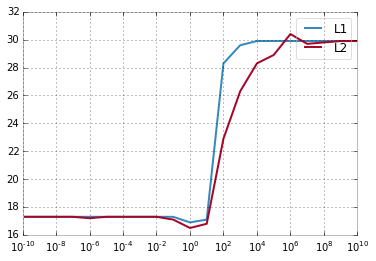

In [31]:
plt.semilogx(penalty_range,errors_l1,label='L1')
plt.semilogx(penalty_range,errors_l2,label='L2')
plt.legend()
plt.show()

In [32]:
k = 10
penalty_range = np.logspace(-2,2,100)
errors_l2 = []
errors_l1 = []
for penalty in penalty_range:
    kfold = KFold(len(X_train), n_folds=k,shuffle=True,random_state=0)
    error_l2 = 0
    error_l1 = 0
    for train_index, val_index in kfold:
        x_train = X_train.iloc[train_index]
        y_train = Y_train.iloc[train_index]
        x_val = X_train.iloc[val_index]
        y_val = Y_train.iloc[val_index]
        lrm_l2 = linear_model.LogisticRegression(C=1./penalty,penalty='l2')
        lrm_l1 = linear_model.LogisticRegression(C=1./penalty,penalty='l1')
        lrm_l2.fit(x_train,y_train)
        lrm_l1.fit(x_train,y_train)
        predicts_l2 = lrm_l2.predict(x_val)
        predicts_l1 = lrm_l1.predict(x_val)
        err_l2 = np.sum(predicts_l2 != y_val.values,dtype=float)
        err_l1 = np.sum(predicts_l1 != y_val.values,dtype=float)
        error_l2 += err_l2
        error_l1 += err_l1
    errors_l2.append(error_l2/k)
    errors_l1.append(error_l1/k)
best_l2 = penalty_range[np.argmin(errors_l2)]
best_l1 = penalty_range[np.argmin(errors_l1)]
print 'best L2:', best_l2
print 'best L1:', best_l1

best L2: 5.09413801482
best L1: 2.91505306283


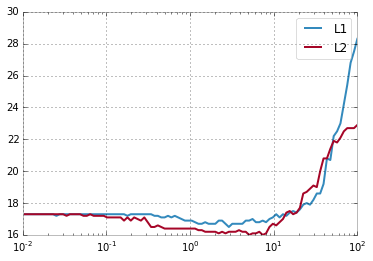

In [33]:
plt.semilogx(penalty_range,errors_l1,label='L1')
plt.semilogx(penalty_range,errors_l2,label='L2')
plt.legend()
plt.show()

# Somewhat less Naive Guess on Test Data

In [34]:
test_lrm = linear_model.LogisticRegression(C=1./best_l2,penalty='l2')

In [35]:
test_lrm.fit(train_x, train_y)
test_predictions = test_lrm.predict(test_x)
print test_predictions

[0 1 0 0 1 0 1 0 1 0 0 0 1 0 1 1 0 0 1 1 0 0 1 0 1 0 1 0 0 0 0 0 1 1 0 0 1
 1 0 0 0 0 0 1 1 0 0 0 1 1 0 0 1 1 0 0 0 0 0 1 0 0 0 1 1 1 1 0 0 1 1 0 1 0
 1 1 0 1 0 1 0 1 0 0 0 0 1 1 1 0 1 0 1 0 0 0 1 0 1 0 1 0 0 0 1 0 0 0 0 0 0
 1 1 1 1 0 0 1 1 1 1 0 1 0 0 1 0 1 0 0 0 0 1 0 0 0 0 0 1 0 0 1 1 0 0 0 0 0
 0 0 1 0 0 1 0 0 1 1 0 1 1 0 1 0 0 1 0 0 1 1 0 0 0 0 0 1 1 0 1 1 0 0 1 0 1
 0 1 0 0 0 0 0 0 0 0 0 1 1 0 1 1 0 1 1 0 0 1 0 1 0 0 0 0 1 0 0 1 1 1 0 1 0
 1 0 1 1 0 1 0 0 0 1 0 0 0 0 0 0 1 1 1 1 1 0 0 0 1 0 1 1 1 0 1 0 0 0 0 0 1
 0 0 0 1 1 0 0 0 0 1 0 1 0 1 1 0 1 0 0 0 0 1 0 1 1 1 0 0 0 0 0 0 1 0 0 0 0
 1 0 0 0 0 0 0 0 1 1 1 0 0 1 0 0 0 1 1 1 1 0 0 0 0 0 0 0 1 0 1 1 0 0 1 0 0
 1 0 0 0 0 0 0 0 0 0 1 0 1 0 1 0 1 1 0 0 0 1 0 1 0 0 1 0 1 1 0 1 1 0 1 1 0
 0 1 0 0 1 1 1 0 0 0 0 0 1 1 0 1 0 0 0 0 1 1 0 0 0 1 0 1 0 0 1 0 1 0 0 0 0
 1 1 1 1 1 1 0 1 0 0 0]


In [36]:
np.savetxt('titanic_L2.csv',
           np.c_[test_x['PassengerId'],test_predictions],
           delimiter=',',
           header='PassengerId,Survived',
           fmt='%d',
           comments='')